In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import math
from sklearn.preprocessing import OneHotEncoder
import datetime

In [2]:
trains=pd.read_csv("trains/trains.csv",
                   usecols=["train_id","origin_station_code", "scheduled_departure",
                            "actual_departure", "destination_station_code","scheduled_arrival",
                            "actual_arrival","delay"],
                   parse_dates=["scheduled_departure","actual_departure",
                                "scheduled_arrival","actual_arrival"],
                  infer_datetime_format=True,
                  dtype={"train_id":np.character,
                          "origin_station_code":np.character,
                          "destination_station_code":np.character,
                          "delay":np.float}
                  )

In [3]:
trains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905645 entries, 0 to 905644
Data columns (total 8 columns):
train_id                    905645 non-null object
origin_station_code         905578 non-null object
scheduled_departure         902568 non-null datetime64[ns]
actual_departure            879895 non-null datetime64[ns]
destination_station_code    905534 non-null object
scheduled_arrival           903864 non-null datetime64[ns]
actual_arrival              875164 non-null datetime64[ns]
delay                       875164 non-null float64
dtypes: datetime64[ns](4), float64(1), object(3)
memory usage: 55.3+ MB


In [4]:
len(trains)

905645

In [5]:
trains.head()

,train_id,origin_station_code,scheduled_departure,actual_departure,destination_station_code,scheduled_arrival,actual_arrival,delay
0,194,NPN,2007-06-16 09:00:00,2007-06-16 09:00:00,BOS,2007-06-16 21:05:00,2007-06-16 22:01:00,56.0
1,194,NPN,2007-06-17 09:00:00,2007-06-17 09:00:00,BOS,2007-06-17 21:05:00,2007-06-17 21:05:00,0.0
2,194,NPN,2007-06-23 09:00:00,2007-06-23 09:00:00,BOS,2007-06-23 21:05:00,2007-06-23 21:36:00,31.0
3,194,NPN,2007-06-24 09:00:00,2007-06-24 09:00:00,BOS,2007-06-24 21:05:00,2007-06-24 21:19:00,14.0
4,194,NPN,2007-06-30 09:00:00,2007-06-30 09:03:00,BOS,2007-06-30 21:05:00,2007-06-30 22:04:00,59.0


## Number of trains canceled

In [6]:
sum(trains["delay"].isna())/len(trains["delay"])

0.033656675628971615

In [7]:
trains["delay_or_zero"]=trains["delay"].apply(lambda x:max(x,0))

In [8]:
mean_delay_per_train=trains.groupby("train_id").filter(lambda x: len(x) > 100).groupby("train_id")["delay"].mean()

In [9]:
mean_delay_per_train.sort_values()

train_id
542    -10.257951
538     -9.799294
744     -8.493878
546     -8.160165
544     -7.614706
540     -7.574719
728     -7.566982
52      -7.377344
467     -6.817927
449     -6.814464
720     -6.591837
534     -6.486374
53      -6.460614
734     -6.341463
520     -6.310223
745     -6.232493
43      -6.224980
751     -6.204023
528     -6.124122
250     -6.099371
738     -5.920270
522     -5.916227
532     -5.730205
746     -5.720327
541     -5.651479
724     -5.584345
524     -5.573847
551     -5.512283
732     -5.501355
536     -5.432721
          ...    
285     29.823232
392     30.699786
64      32.607301
354     33.963036
83      34.300766
51      34.675235
95      35.142584
97      36.282308
92      39.396830
7       39.565283
4       40.767832
98      41.856887
48      41.995557
19      42.683518
448     42.830798
89      45.741461
2       46.454159
5       47.777842
352     48.297791
29      51.015148
79      51.817547
30      51.849835
27      51.905294
78      53.364706
9

In [10]:
std_delay_per_train=trains.groupby("train_id").filter(lambda x: len(x) > 100).groupby("train_id")["delay"].std()
std_delay_per_train.sort_values()

train_id
531       6.377400
495       6.895254
615       7.132788
2205      7.553752
533       7.655168
679       8.047323
260       8.438517
230       8.641416
620       8.788467
529       8.884611
520       8.994616
609       9.005528
525       9.099437
601       9.104817
334       9.190060
522       9.364478
600       9.422720
526       9.670967
733       9.861133
541       9.988499
2208     10.006731
732      10.109073
749      10.193909
530      10.239105
534      10.276892
2103     10.279451
720      10.314506
2100     10.371879
336      10.533100
545      10.533586
           ...    
89       62.420623
90       63.179521
19       72.370543
51       76.128959
91       79.433422
97       83.482216
29       84.838464
20       84.844193
11       85.622103
14       87.481689
92       87.662424
49       87.663548
48       87.799165
98       88.033565
30       91.359397
448      92.136118
53       94.366869
21       94.703650
52      102.098655
4       105.724136
50      108.040488
3  

In [11]:
mean_delay_per_destination=trains.groupby("destination_station_code").filter(lambda x: len(x) > 100).groupby("destination_station_code")["delay"].mean()

In [12]:
mean_delay_per_destination.sort_values()

destination_station_code
LOR    -7.377344
SFA    -6.460614
PGH    -6.216737
SAC    -5.134580
ARN    -4.860388
OAC    -2.167650
SJC    -1.164219
PHL     0.512891
KCY     1.552404
IRV     1.647059
NFK     2.081402
OKJ     2.117067
MKE     2.168981
ALB     2.559028
NHV     2.713281
QCY     2.767657
NYG     3.310680
HAR     3.635153
PTH     4.468428
BFD     4.706856
RUD     7.053919
EUG     7.065746
ATL     7.223602
SAN     8.161572
GTA     8.376965
BEL     8.506173
OKC     8.540753
WAS     9.399395
SLO     9.673081
OSD     9.878689
         ...    
LAX    11.364089
NYP    11.639563
BRK    12.198280
BOS    12.202708
BON    12.336310
FTW    12.804581
SPG    13.154432
WEM    13.299213
SEA    13.652652
GRR    15.013408
VAC    15.219728
NFL    16.442370
LYH    16.467658
CDL    18.190426
PDX    18.390672
IND    18.970769
MTR    19.764454
SAB    19.800000
RVR    20.718102
SAS    22.150378
NPN    22.314852
CLT    24.461583
CHI    26.251690
NOL    26.542453
BNL    27.113636
TWO    29.578084
PNT   

## Mean delay (min) per day of the week (arrival)

In [13]:
trains["arrival_dow"]=trains["scheduled_arrival"].dt.weekday

In [14]:
mean_delay_per_dow=trains.groupby("arrival_dow")["delay"].mean()

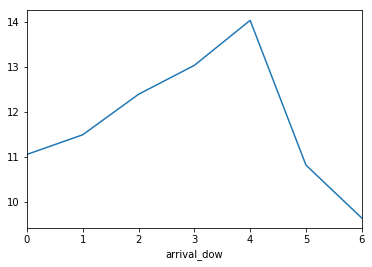

In [15]:
mean_delay_per_dow.plot()

## Mean delay (min) per day of the week (departure)

In [16]:
trains["departure_dow"]=trains["scheduled_departure"].dt.weekday

In [17]:
mean_delay_per_dow_dep=trains.groupby("departure_dow")["delay"].mean()

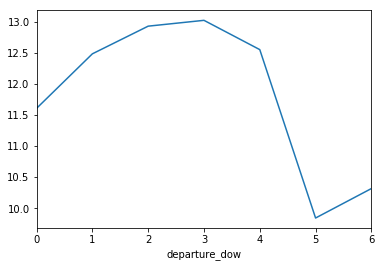

In [18]:
mean_delay_per_dow_dep.plot()

## Mean delay (min) per year

In [19]:
trains["year"]=trains["scheduled_departure"].dt.year

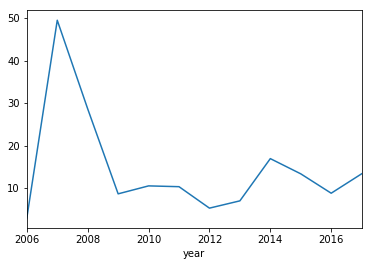

In [20]:
mean_delay_per_year=trains.groupby("year")["delay"].mean()
mean_delay_per_year.plot()

## Mean delay (min) per month

In [21]:
trains["month"]=trains["scheduled_departure"].dt.month

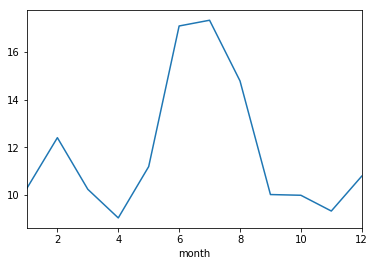

In [22]:
mean_delay_per_month=trains.groupby("month")["delay"].mean()
mean_delay_per_month.plot()

## Mean delay (min) per week

In [23]:
trains["week"]=trains["scheduled_departure"].dt.week

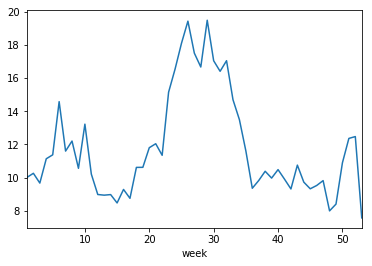

In [24]:
mean_delay_per_week=trains.groupby("week")["delay"].mean()
mean_delay_per_week.plot()

## Mean delay (min) per day of the year

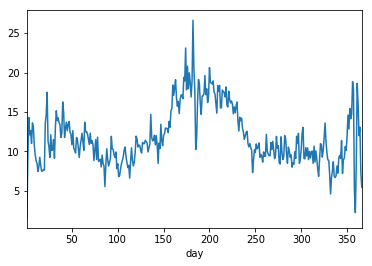

In [25]:
trains["day"]=trains["scheduled_departure"].dt.dayofyear
mean_delay_per_day=trains.groupby(["day"])["delay"].mean()
mean_delay_per_day.plot()

## Delay length plot per train id

In [26]:
relevant_number_train_ids=set(trains.groupby("train_id").filter(lambda x: len(x) > 100)["train_id"])

In [27]:
trains["long_delay_or_cancelled"] = (trains["delay"] >= 30) | (trains["delay"].isna())

In [28]:
trains["30min_delayed"]=(~trains["delay"].isna())&(60>trains["delay"])&(trains["delay"]>=30)
trains["1h_delayed"]=(~trains["delay"].isna())&(180>trains["delay"])&(trains["delay"]>=60)
trains["3h_delayed"]=(~trains["delay"].isna())&(360>trains["delay"])&(trains["delay"]>=180)
trains["more_6h_delayed"]=(~trains["delay"].isna())&(trains["delay"]>=360)
trains["cancelled"]=trains["delay"].isna()

In [29]:
relevant_trains=trains[trains["train_id"].isin(relevant_number_train_ids)]

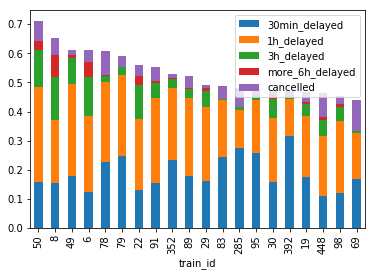

In [30]:
relevant_trains.groupby('train_id')[
    ['long_delay_or_cancelled',"30min_delayed","1h_delayed",
     "3h_delayed","more_6h_delayed","cancelled"]
    ].mean().sort_values(
    ascending=False,by='long_delay_or_cancelled'
)[["30min_delayed",
   "1h_delayed",
   "3h_delayed",
   "more_6h_delayed",
   "cancelled"]
 ].head(20).plot(kind='bar',stacked=True)

# Predicting delay

In [31]:
class ColumnPrep:
    """Utility class that does one-hot-encoding of categories
    and normalization of numeric input.
    """
    def __init__(self,train_data,ignore=[],label=None,na_cutoff=1,is_category=[],
                 fill_zero_na_pre=[],fill_zero_na_post=[],to_predict_data=None):
        self.train_data=train_data
        self.cat_columns=[]
        self.num_columns=[]
        self.one_hot_encoder=OneHotEncoder(handle_unknown='ignore') #todo - replace with pandas get_dummy
        self.ignore=ignore
        self.label=label
        self.is_category=is_category
        self.na_cutoff=na_cutoff #ratio of how many rows at most can be NA for the column to be considered
        self.na_category="None"
        
        self.to_predict_data=to_predict_data
        self.fill_zero_na_pre=fill_zero_na_pre
        self.fill_zero_na_post=fill_zero_na_post
        
        self.normalize_data={}
        
        self.decide_cols_()

    def is_good_category_(self,col):
        if self.to_predict_data is None:
            return True
        to_predict_cats=set(self.to_predict_data[col].unique())
        untrainable=to_predict_cats-set(self.train_data[col].unique())
        if len(untrainable)>0:
            print(f"{col} - {untrainable}")
            return False

        val_counts=data[col].value_counts(dropna=False).to_dict()
        print(val_counts)
        for c in val_counts.keys():
            if val_counts[c]<10:
                if c in to_predict_cats:
                    return False
        return True
        
    def decide_cols_(self):
        for c in self.train_data.columns:
            if c in self.ignore or c==self.label:
                continue
            na_count=sum(self.train_data[c].isna())
            if na_count/len(self.train_data)<self.na_cutoff:
                dtype=str(self.train_data[c].dtype)
                if "object" in dtype or "category" in dtype or c in self.is_category:
                    if self.is_good_category_(c):
                        self.cat_columns+=[c]
                        self.train_data[c]=self.train_data[c].fillna(self.na_category)
                    else:
                        print(f"Dropping {c}")
                elif "float" in dtype:
                    self.num_columns+=[c]
                elif "int" in dtype:
                    if len(set(self.train_data[c]))<10 and self.is_good_category_(c):
                        self.cat_columns+=[c]
                        self.train_data[c]=self.train_data[c].fillna(-999912312)
                    else:
                        self.num_columns+=[c]
                else:
                    #unknown dtype
                    self.cat_columns+=[c]
                    self.train_data[c]=self.train_data[c].fillna(self.na_category)
        
        for c in self.num_columns:
            self.normalize_data[c]=(self.train_data[c].mean(),self.train_data[c].std())
        
        self.one_hot_encoder.fit(self.train_data[self.cat_columns])
                        
    def transform(self,data):
        df=data[self.num_columns].join(pd.DataFrame(self.one_hot_encoder.transform(
            data[self.cat_columns].fillna(self.na_category)).toarray(),index=data.index))
        if self.label in data.columns:
            df=df.join(data[self.label])
        df[self.fill_zero_na_pre]=df[self.fill_zero_na_pre].fillna(0)
        for c in self.num_columns:
            mean,std=self.normalize_data[c]
            df[c]=(df[c]-mean)/std
        df=df.fillna(0)
        return df

In [32]:
train_data=trains[["train_id","delay"]].copy()

In [33]:
q=trains["scheduled_departure"].fillna(value=trains["actual_departure"])
train_data["dep_timestamp"]=(q.apply(lambda x:x.timestamp() if not pd.isna(x) else np.nan)).astype("Int64")
train_data["weekday"]=q.dt.dayofweek
train_data["season"]=(q.apply(lambda d:math.cos(2*math.pi*(d.dayofyear)/(365+int(d.is_leap_year)))
                              if not pd.isna(d) else np.nan))
train_data["arr_timestamp"]=(trains["scheduled_arrival"].fillna(value=trains["actual_arrival"])
                             .apply(lambda x:x.timestamp() if not pd.isna(x) else np.nan))

In [34]:
train_data=train_data.dropna()

In [35]:
count_train_id=train_data["train_id"].value_counts()

In [36]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875097 entries, 0 to 905644
Data columns (total 6 columns):
train_id         875097 non-null object
delay            875097 non-null float64
dep_timestamp    875097 non-null Int64
weekday          875097 non-null float64
season           875097 non-null float64
arr_timestamp    875097 non-null float64
dtypes: Int64(1), float64(4), object(1)
memory usage: 47.6+ MB


In [37]:
train_data["arr_timestamp"]=train_data["arr_timestamp"].astype("int64")
train_data["dep_timestamp"]=train_data["dep_timestamp"].astype("int64")
train_data["weekday"]=train_data["weekday"].astype("int64")
train_data["delay"]=train_data["delay"].astype("int64")
train_data["duration"]=train_data["arr_timestamp"]-train_data["dep_timestamp"]
_=train_data.pop("arr_timestamp")

In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875097 entries, 0 to 905644
Data columns (total 6 columns):
train_id         875097 non-null object
delay            875097 non-null int64
dep_timestamp    875097 non-null int64
weekday          875097 non-null int64
season           875097 non-null float64
duration         875097 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 46.7+ MB


In [39]:
enough_data_trains=count_train_id[count_train_id>3000].index
train_data_red=train_data[train_data["train_id"].isin(enough_data_trains)].copy()

In [40]:
train_pre_date=train_data_red[train_data_red["dep_timestamp"]<datetime.datetime(2017,1,1).timestamp()].copy()
train_post_date=train_data_red.drop(train_pre_date.index)

In [41]:
cp=ColumnPrep(train_pre_date,label="delay")
train_pre_tf=cp.transform(train_pre_date)
train_pre_label=train_pre_tf.pop("delay")
xgb_pre_train=xgb.DMatrix(train_pre_tf,label=train_pre_label)

/home/phil/python/jupyter/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/phil/python/jupyter/env/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [42]:
param = {'max_depth': 4, 'eta': 0.1, "subsample":0.7,"verbosity":0}
bst=xgb.train(param,xgb_pre_train,num_boost_round=300)

In [43]:
train_post_tf=cp.transform(train_post_date)
real_delay=train_post_tf.pop("delay")
xgb_post_train=xgb.DMatrix(train_post_tf)
pred_delay=bst.predict(xgb_post_train)

In [44]:
abs(real_delay-pred_delay).mean()

37.84872210879594

In [45]:
pred_delay_df=pd.DataFrame(pred_delay,columns=["predicted"],index=real_delay.index)
train_data_comp=train_post_date.join(pred_delay_df)

In [46]:
train_data_comp.head()

,train_id,delay,dep_timestamp,weekday,season,duration,predicted
798779,11,-36,1483263300,6,0.999852,127500,38.570644
798780,11,2,1483349700,0,0.999407,127500,36.408604
798781,11,66,1483436100,1,0.998667,127500,44.126736
798782,11,280,1483522500,2,0.997630,127500,40.119377
798783,11,66,1483608900,3,0.996298,127500,37.428871


## Actual mean delay in 2017 vs. prediction for day of the week

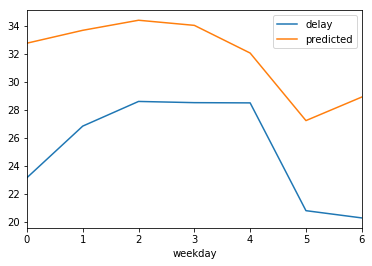

In [47]:
per_week_day=train_data_comp.groupby("weekday")[["delay","predicted"]].mean()
per_week_day.plot()

## Actual mean delay in 2017 vs. prediction for "season" (-1 summer, 1 winter, 0 fall or spring)

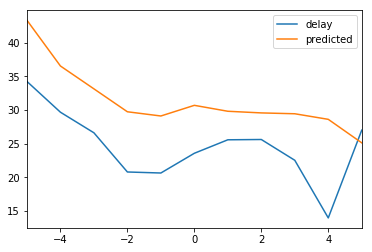

In [48]:
per_season=train_data_comp.groupby(lambda x:round(train_data_comp.loc[x]["season"]*5))[["delay","predicted"]].mean()
per_season.plot()